In [1]:
# Calling libraries:
from __future__ import division
%matplotlib inline
import numpy as np, time, matplotlib.pyplot as plt, math, pandas, numpy.random as npr, pystan as ps, pickle
from pylab import plot, show, legend
from time import time
from scipy.stats import *

In [2]:
sm = ps.StanModel(file="garch_WB.stan")

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_f0ef85016fbe1114f4bfb9978c846a08 NOW.


In [77]:
T = 10_000
p = 5
q = 5
r = max(p,q)
d = 50
y = np.zeros(T)
X = npr.randn(d,T)
omega = npr.rand()
beta = npr.rand(p)/5
alpha = npr.rand(q)/5
b = npr.randn(d)

In [78]:
sigsq = np.ones(T)
for t in np.arange(0,r) :
    y[t] = np.sqrt(sigsq[t])*npr.randn() + b.dot(X[:,t])
for t in np.arange(r,T) :
    sigsq[t] = omega + alpha.dot((y[t-q:t]-b.dot(X[:,t-q:t]))**2) + beta.dot(sigsq[t-p:t]) 
    y[t] = np.sqrt(sigsq[t])*npr.randn() + b.dot(X[:,t])

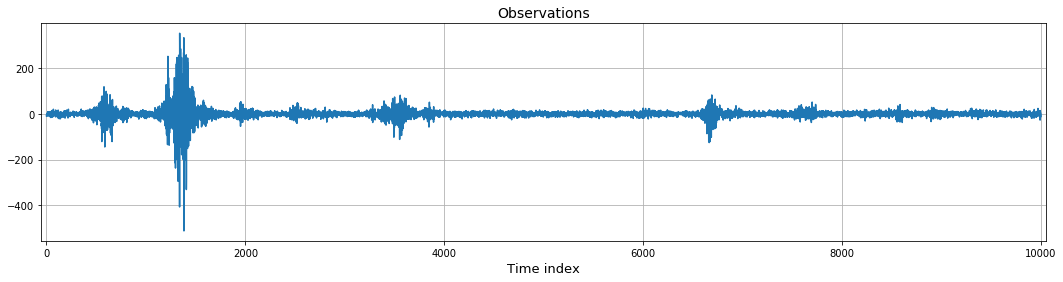

In [79]:
plt.figure(figsize=(18,4))
plt.plot(y)
plt.xlim(-0.005*T,1.005*T)
plt.title("Observations", fontsize=14)
plt.xlabel("Time index", fontsize=13)
plt.grid(True);

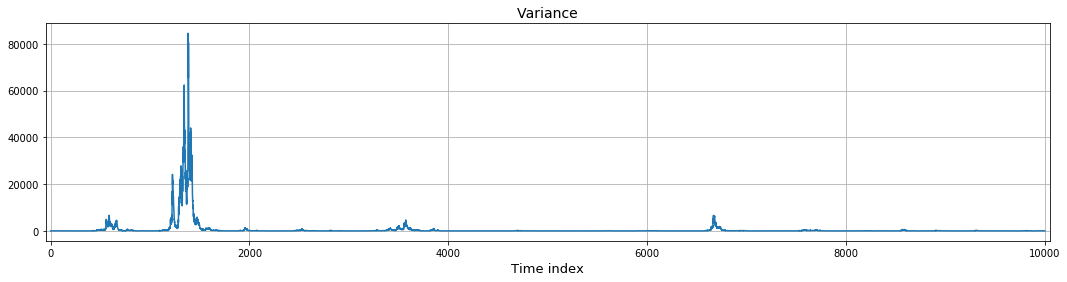

In [80]:
plt.figure(figsize=(18,4))
plt.plot(sigsq)
plt.xlim(-0.005*T,1.005*T)
plt.title("Variance", fontsize=14)
plt.xlabel("Time index", fontsize=13)
plt.grid(True);

In [25]:
d

50

### MCMC on full dataset:

In [ ]:
n_chains = 10

tstart, tend = 0, T;
data = dict(T=tend-tstart, p=p, q=q, r=max(p,q), d=d, y=y[tstart:tend], X=X[:,tstart:tend], power=1)
start = time()
fit = sm.sampling(data=data, thin=1, n_jobs=min(10,n_chains), chains=n_chains, init="random", iter=500)
print(round((time()-start)/60,2), "minutes to run")

file = open("/xtmp/DC-BATS_data/garch/full_mcmc.pkl", "wb")
trace = fit.extract()
pickle.dump(fit.extract(), file)
file.close()

#### Get credible intervals:

In [83]:
file = open("/xtmp/DC-BATS_data/garch/full_mcmc.pkl", "rb")
trace = pickle.load(file)
file.close()

b_ci_full = np.percentile(trace['b'],axis=0,q=[2.5,97.5])
beta_ci_full = np.percentile(trace['beta'],axis=0,q=[2.5,97.5])
alpha_ci_full = np.percentile(trace['alpha'],axis=0,q=[2.5,97.5])
omega_ci_full = np.percentile(trace['omega'],axis=0,q=[2.5,97.5])

### Divide-and-conquer:

In [ ]:
m = 10
tstarts = np.arange(m).astype(int)
tends = 1 + tstarts
tstarts *= int(T/m)
tends *= int(T/m)

In [ ]:
for i in range(m) :
    tstart, tend = tstarts[i], tends[i]
    dict(T=tend-tstart, p=p, q=q, r=max(p,q), d=d, y=y[tstart:tend], X=X[:,tstart:tend], power=T/(tend-tstart))
    start = time()
    fit = sm.sampling(data=data, thin=1, n_jobs=min(10,n_chains), chains=n_chains, init="random", iter=500)
    print(round((time()-start)/60,2), "minutes to run chunk", i+1)
    file = open("/xtmp/DC-BATS_data/garch/mcmc_wb_chunk"+str(i+1)+".pkl", "wb")
    pickle.dump(fit.extract(), file)
    file.close()

#### Get credible intervals:

In [84]:
b_ci_dc = np.zeros((2,d))
beta_ci_dc = np.zeros((2,p))
alpha_ci_dc = np.zeros((2,q))
omega_ci_dc = np.zeros(2)
for i in range(m) :
    file = open("/xtmp/DC-BATS_data/garch/mcmc_wb_chunk"+str(i+1)+".pkl", "rb")
    trace = pickle.load(file)
    b_ci_dc += np.percentile(trace['b'],axis=0,q=[2.5,97.5])/m
    beta_ci_dc += np.percentile(trace['beta'],axis=0,q=[2.5,97.5])/m
    alpha_ci_dc += np.percentile(trace['alpha'],axis=0,q=[2.5,97.5])/m
    omega_ci_dc += np.percentile(trace['omega'],axis=0,q=[2.5,97.5])/m

### Compare credible intervals:

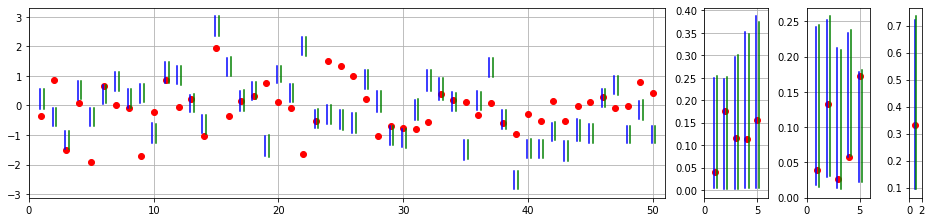

In [85]:
plt.rcParams['axes.grid'] = True
f, (a0, a1, a2, a3) = plt.subplots(1, 4, gridspec_kw={'width_ratios': [d, p, q, 1]}, figsize=(16,3.5))
a0.plot(np.arange(1,d+1), b, "ro")
for i in range(d) :
    a0.plot([i+0.9,i+0.9], b_ci_dc[:,i], "b-")
    a0.plot([i+1.2,i+1.2], b_ci_full[:,i], "g-")
a0.axis(xmin=0,xmax=d+1)
a1.plot(np.arange(1,p+1), beta, "ro")
for i in range(p) :
    a1.plot([i+0.9,i+0.9], beta_ci_dc[:,i], "b-")
    a1.plot([i+1.2,i+1.2], beta_ci_full[:,i], "g-")
a1.axis(xmin=0,xmax=p+1)
a2.plot(np.arange(1,q+1), alpha, "ro")
for i in range(q) :
    a2.plot([i+0.9,i+0.9], alpha_ci_dc[:,i], "b-")
    a2.plot([i+1.2,i+1.2], alpha_ci_full[:,i], "g-")
a2.axis(xmin=0,xmax=q+1)
a3.plot(1, omega, "ro")
a3.plot([0.95,0.95], omega_ci_dc, "b-")
a3.plot([1.05,1.05], omega_ci_full, "g-")
a3.axis(xmin=0,xmax=2);

In [86]:
print(np.mean(b_ci_dc[1]-b_ci_dc[0])/np.mean(b_ci_full[1]-b_ci_full[0]))
print(np.mean(beta_ci_dc[1]-beta_ci_dc[0])/np.mean(beta_ci_full[1]-beta_ci_full[0]))
print(np.mean(alpha_ci_dc[1]-alpha_ci_dc[0])/np.mean(alpha_ci_full[1]-alpha_ci_full[0]))

0.9972293069485783
1.0020396497524544
0.9850306408481271


In [ ]:
1